In [ ]:
"""
Context

    This dataset is created for prediction of Graduate Admissions from an Indian perspective.

Content

The dataset contains several parameters which are considered important during the application for Masters Programs. 
The parameters included are :

-GRE Scores ( out of 340 )
-TOEFL Scores ( out of 120 )
-University Rating ( out of 5 )
-Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
-Undergraduate GPA ( out of 10 )
-Research Experience ( either 0 or 1 )
-Chance of Admit ( ranging from 0 to 1 )
"""

In [93]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#ML libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#metrics
from sklearn import metrics


In [94]:
data = pd.read_csv(os.getcwd() + '/archive/Admission_Predict.csv')

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [96]:
data.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

In [97]:
data = data.drop('Serial No.', axis = 1)
data.describe()

GRE Score  TOEFL Score  University Rating         SOP        LOR   \
count  400.000000   400.000000         400.000000  400.000000  400.000000   
mean   316.807500   107.410000           3.087500    3.400000    3.452500   
std     11.473646     6.069514           1.143728    1.006869    0.898478   
min    290.000000    92.000000           1.000000    1.000000    1.000000   
25%    308.000000   103.000000           2.000000    2.500000    3.000000   
50%    317.000000   107.000000           3.000000    3.500000    3.500000   
75%    325.000000   112.000000           4.000000    4.000000    4.000000   
max    340.000000   120.000000           5.000000    5.000000    5.000000   

             CGPA    Research  Chance of Admit   
count  400.000000  400.000000        400.000000  
mean     8.598925    0.547500          0.724350  
std      0.596317    0.498362          0.142609  
min      6.800000    0.000000          0.340000  
25%      8.170000    0.000000          0.640000  
50%      8.610000    1.000000          0.730000  
75%      9.062500    1.000000          0.830000  
max      9.920000    1.000000          0.970000

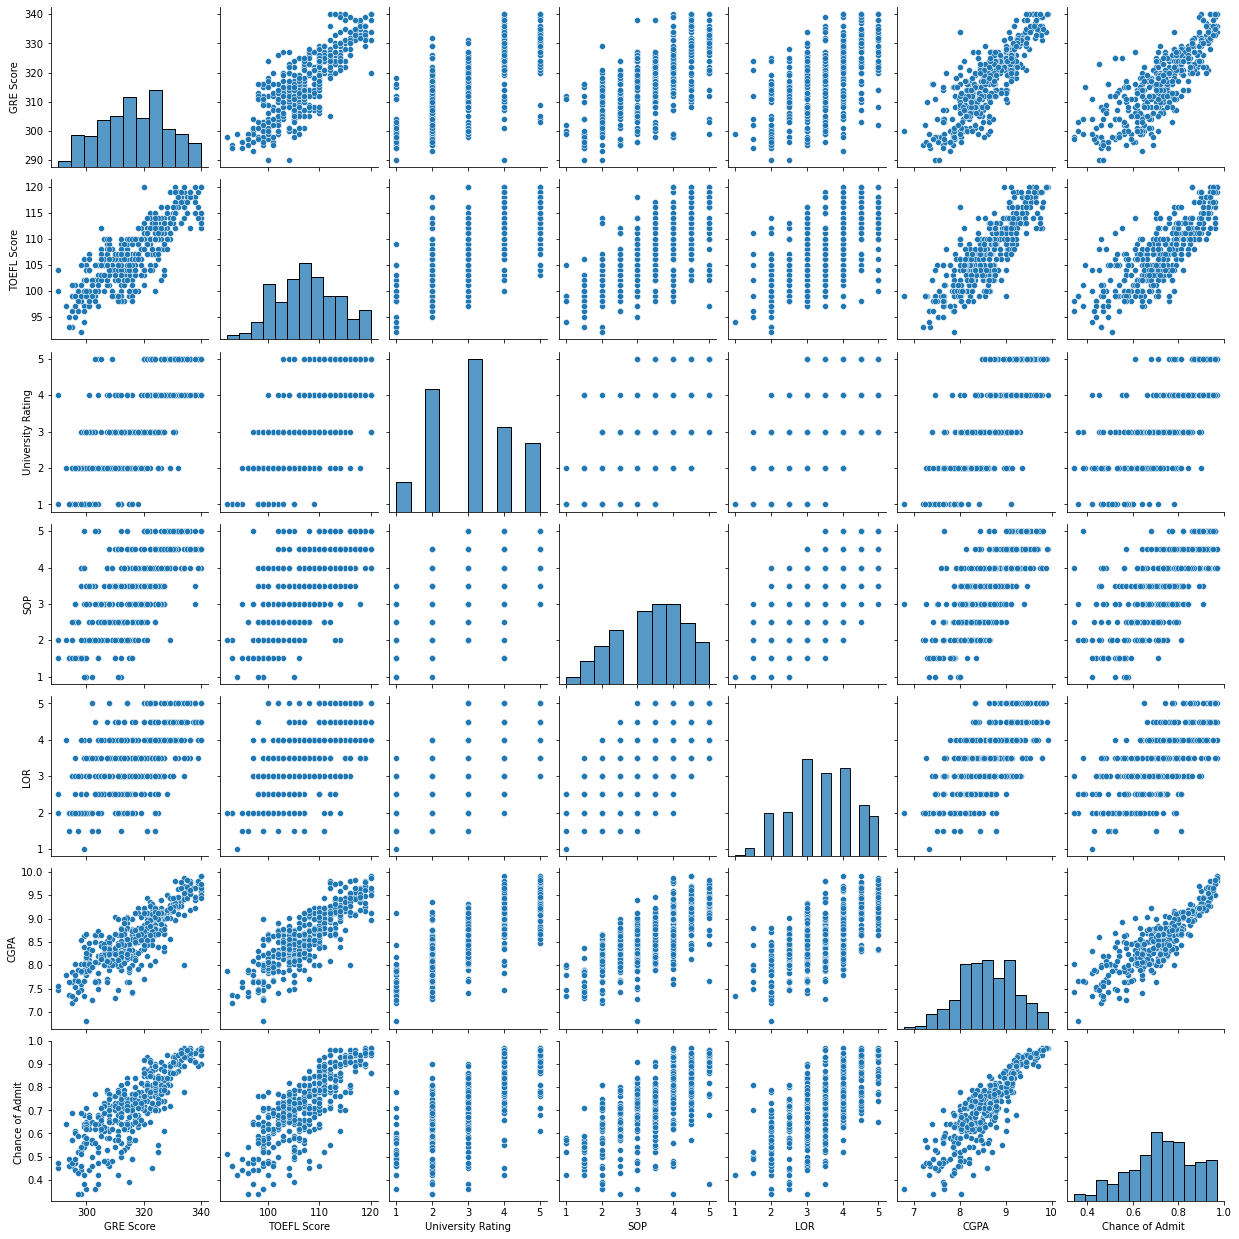

In [134]:
sns.pairplot(data)

In [99]:
data.corr(method = 'pearson')

GRE Score  TOEFL Score  University Rating       SOP  \
GRE Score           1.000000     0.835977           0.668976  0.612831   
TOEFL Score         0.835977     1.000000           0.695590  0.657981   
University Rating   0.668976     0.695590           1.000000  0.734523   
SOP                 0.612831     0.657981           0.734523  1.000000   
LOR                 0.557555     0.567721           0.660123  0.729593   
CGPA                0.833060     0.828417           0.746479  0.718144   
Research            0.580391     0.489858           0.447783  0.444029   
Chance of Admit     0.802610     0.791594           0.711250  0.675732   

                       LOR       CGPA  Research  Chance of Admit   
GRE Score          0.557555  0.833060  0.580391          0.802610  
TOEFL Score        0.567721  0.828417  0.489858          0.791594  
University Rating  0.660123  0.746479  0.447783          0.711250  
SOP                0.729593  0.718144  0.444029          0.675732  
LOR                1.000000  0.670211  0.396859          0.669889  
CGPA               0.670211  1.000000  0.521654          0.873289  
Research           0.396859  0.521654  1.000000          0.553202  
Chance of Admit    0.669889  0.873289  0.553202          1.000000

<AxesSubplot:>

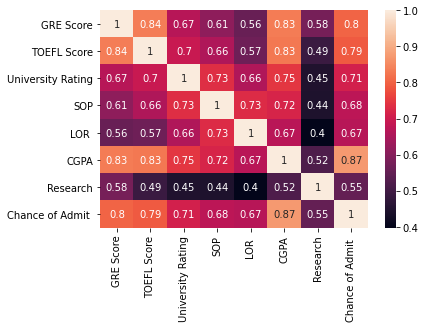

In [100]:
sns.heatmap(data.corr(method = 'pearson'), annot = True)

In [101]:
#еще попробуем убрать проблему коллинеарности в переменной 'Research'
#преобразуем все категориальные переменные в тип данных 'category' 
data['Research'] = data['Research'].astype('category')
#get dummies for all features but remove the first one(avoid multicollinearity) also called Dummy Variable Trap
data_encoded = pd.get_dummies(data, drop_first= True)

In [102]:
#разделим массив
target = data_encoded['Chance of Admit ']
X_features = data_encoded.drop(['Chance of Admit '], axis = 1)

In [103]:
#scalling features
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_features_scaled = scaler.fit_transform(X_features)

In [104]:
train_X, test_X, train_y, test_y = train_test_split(X_features, target, 
                                                    test_size=0.2, shuffle = True, random_state=1)

In [105]:
#i select the number of main components to achieve maximum 'roc_auc_score' metric, it turned out "5"
#pca = PCA(n_components=7)
#train_X_pca = pca.fit_transform(train_X)
#test_X_pca = pca.transform(test_X)

-----линейная регрессия-----

In [106]:
LR = LinearRegression()
LR.fit(train_X, train_y)
LR.score(test_X, test_y)

0.8079043677020099

In [107]:
pred_y = LR.predict(test_X)

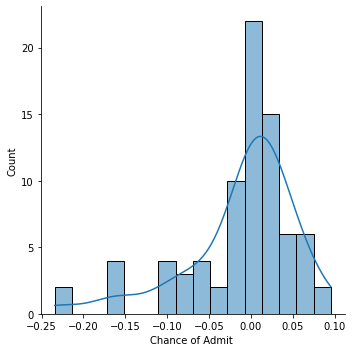

In [111]:
sns.displot(test_y - pred_y, kde = True, bins = int(test_y.count()/5))

In [112]:
#метрики
print('Линейная регрессия')
print(' MAE:', metrics.mean_absolute_error(test_y, pred_y))
print(' MSE:', metrics.mean_squared_error(test_y, pred_y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_y)))

Линейная регрессия
 MAE: 0.04495779899577674
 MSE: 0.004442679729994746
RMSE: 0.06665342999422269


-----случайный лес-----

In [113]:
RFR = RandomForestRegressor()

In [114]:
#searching the best hyperparameters for RFC model
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rs = RandomizedSearchCV(RFR, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(train_X, train_y)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 761,
 'min_samples_split': 18,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 9,
 'bootstrap': True}

In [115]:
#applying the best parameters to the model
RFR = rs.best_estimator_
#fit the model
RFR.fit(train_X, train_y)
#score prediction of test sample
RFR.score(test_X, test_y) 

0.7788361083781662

In [116]:
pred_y = RFR.predict(test_X)

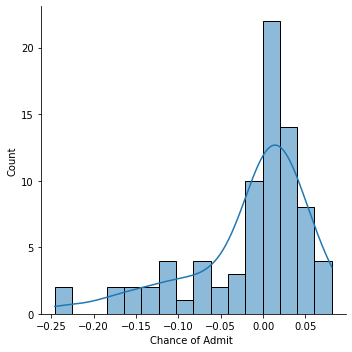

In [118]:
sns.displot(test_y - pred_y, kde = True, bins = int(test_y.count()/5))

In [119]:
#метрики
print('Случайный лес')
print(' MAE:', metrics.mean_absolute_error(test_y, pred_y))
print(' MSE:', metrics.mean_squared_error(test_y, pred_y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_y)))

Случайный лес
 MAE: 0.04847592597845687
 MSE: 0.005114954080740733
RMSE: 0.07151890715566572


-----метод опорных векторов(ядерных)-----

In [120]:
SVR_ = SVR()

In [121]:
C = [int(x) for x in np.linspace(start = 1, stop = 100000, num = 1000)]
epsilon = [x for x in np.linspace(start = 0.01, stop = 10, num = 50)]

param_dist = {
                'C' : C,
                'epsilon' : epsilon
            }

rs = RandomizedSearchCV(SVR_, 
                        param_dist,
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(train_X, train_y)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'epsilon': 0.01, 'C': 29330}

In [123]:
#applying the best parameters to the model
SVR_ = rs.best_estimator_
#fit the model
SVR_.fit(train_X, train_y)
#calcuting 'roc_auc_score' metric
SVR_.score(test_X, test_y)

0.7902029878921761

In [124]:
pred_y = SVR_.predict(test_X)

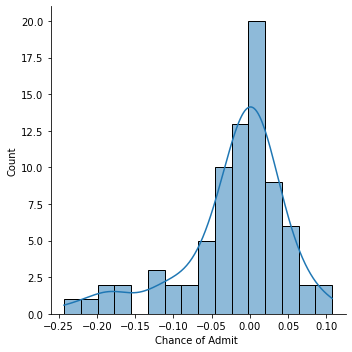

In [126]:
sns.displot(test_y - pred_y, kde = True, bins = int(test_y.count()/5))

In [127]:
#метрики
print('Метод опорных векторов')
print(' MAE:', metrics.mean_absolute_error(test_y, pred_y))
print(' MSE:', metrics.mean_squared_error(test_y, pred_y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_y)))

Метод опорных векторов
 MAE: 0.044866992532024925
 MSE: 0.0048520672852104384
RMSE: 0.0696567820474822
